In [33]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.3)

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [232]:
file = '../data/with_tokenized.csv'
df = pd.read_csv(file)

/Users/sueliu/Mudano/customer-complaints/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [204]:
df.Product.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    148581
Debt collection                                                                  95954
Mortgage                                                                         57037
Credit card or prepaid card                                                      46671
Bank account or service                                                          30736
Student loan                                                                     23414
Consumer Loan                                                                    16310
Money transfer, virtual currency, or money service                                8014
Payday loan, title loan, or personal loan                                         7028
Other financial service                                                            292
Name: Product, dtype: int64

In [233]:
debt_df = df[df['Product'] == 'Debt collection']

In [234]:
debt_df.to_csv('../data/debt_only.csv', index=False)

In [169]:
model_df = debt_df[['Complaint ID', 'tokenized_text', 'Issue']].dropna()
model_df = model_df[model_df['tokenized_text'].str.len() >= 10]

In [170]:
abbrev_map = {
    'Attempts to collect debt not owed' : 'DNO',
    'Communication tactics': 'CT',
    "Cont'd attempts collect debt not owed": 'CDNO',
    "Disclosure verification of debt": 'DV',
    "False statements or representation": 'FS',
    "Improper contact or sharing of info": 'IC',
    "Taking/threatening an illegal action": 'TIA',
    "Threatened to contact someone or share information improperly": 'IC',
    "Took or threatened to take negative or legal action": 'TNA',
    "Written notification about debt": 'WN'
}
model_df['target'] = model_df['Issue'].apply(lambda i: abbrev_map[i])

In [235]:
valid_types = ['DNO', 'CT', 'WN', 'FS', 'DV', 'TNA']
model_df = model_df[model_df['target'].isin(valid_types)]
targets = sorted(model_df['target'].unique())

In [236]:
train_df, test_df = train_test_split(model_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

X_train, X_val = train_df['tokenized_text'].values, val_df['tokenized_text'].values
y_train, y_val = train_df['target'].values, val_df['target'].values

In [237]:
tfidf_vect = TfidfVectorizer(analyzer='word', max_features=1500, ngram_range=(1, 3))
tfidf_vect.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=1500,
                min_df=1, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [238]:
X_train_tfidf = tfidf_vect.transform(X_train)
X_val_tfidf = tfidf_vect.transform(X_val)

In [239]:
from sklearn.linear_model import LogisticRegressionCV

In [240]:
lr = LogisticRegressionCV(max_iter=500, class_weight='balanced', multi_class='auto',
                       solver='lbfgs', n_jobs=3, random_state=42)
lr.fit(X_train_tfidf, y_train)

/Users/sueliu/Mudano/customer-complaints/venv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


LogisticRegressionCV(Cs=10, class_weight='balanced', cv='warn', dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=500, multi_class='auto', n_jobs=3, penalty='l2',
                     random_state=42, refit=True, scoring=None, solver='lbfgs',
                     tol=0.0001, verbose=0)

In [218]:
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint

In [220]:
rf = RandomForestClassifier(random_state=42)
pprint('Parameters currently in use:')
pprint(rf.get_params())

'Parameters currently in use:'
{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


The most important settings are the number of trees in the forest (`n_estimators`) and the number of features considered for splitting at each leaf node (`max_features`)

Let's adjust the following set of hyperparameters:
* `n_estimators`: number of trees in the forest
* `max_features`: maximum number of features considered for splitting a node
* `max_depth`: maximum number of levels in each decision tree
* `min_samples_split`: minimum number of data points placed in a node before the node is split
* `min_samples_leaf`: minimum number of data points allowed in a leaf node
* `bootstrap`: method for sampling data points (with or without replacement)

In [225]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=100, stop=2000, num=10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num=10)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000]}


In [241]:
model = lr
pred = model.predict(X_val_tfidf)
val_df['pred'] = pred
pred_proba = model.predict_proba(X_val_tfidf)
proba_df = pd.DataFrame(pred_proba, columns=['pred_'+t for t in sorted(targets)])
proba_df['max_prob'] = proba_df.max(axis=1)
proba_df['Complaint ID'] = val_df['Complaint ID'].values

merged = pd.merge(val_df, proba_df, on='Complaint ID')
threshold = merged[merged['max_prob'] > 0]

In [242]:
print(classification_report(threshold['target'], threshold['pred']))

              precision    recall  f1-score   support

          CT       0.72      0.74      0.72      2103
         DNO       0.70      0.48      0.57      3820
          DV       0.33      0.40      0.36      1186
          FS       0.37      0.46      0.41      1493
         TNA       0.34      0.46      0.39      1066
          WN       0.44      0.47      0.45      1669

    accuracy                           0.51     11337
   macro avg       0.48      0.50      0.48     11337
weighted avg       0.55      0.51      0.52     11337



In [ ]:
def generate_test_preds(model, test_df):
    X_test, y_test = test_df['tokenized_text'].values, test_df['target']
    X_test_tfidf = tfidf_vect.transform(X_test)
    pred = model.predict(X_test_tfidf)
    
    test_df['pred'] = pred
    pred_proba = model.predict_proba(X_test_tfidf)
    proba_df = pd.DataFrame(pred_proba, columns=['pred_'+t for t in sorted(valid_types)])
    proba_df['max_prob'] = proba_df.max(axis=1)
    proba_df['Complaint ID'] = test_df['Complaint ID'].values

    merged = pd.merge(test_df, proba_df, on='Complaint ID')

    orig_df = pd.read_csv('../data/Consumer_Complaints.csv', 
                      usecols=['Complaint ID', 'Consumer complaint narrative'])
    with_narrative_df = pd.merge(merged, orig_df, on='Complaint ID')
    with_narrative_df.to_csv('../output/debts_predictions.csv', index=False)

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)

In [23]:
support = np.sum(confusion_matrix(val_df['target'], val_df['pred']), axis=1)
total_pred = np.sum(confusion_matrix(val_df['target'], val_df['pred']), axis=0)

In [24]:
cm = confusion_matrix(val_df['target'], val_df['pred'])

In [25]:
precision_matrix = cm/total_pred
recall_matrix = cm/support

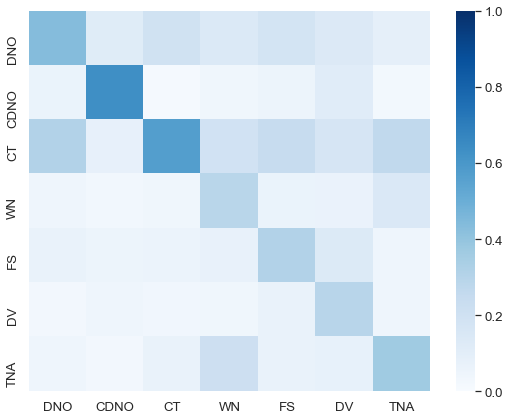

In [27]:
f, ax = plt.subplots(figsize=(9, 7))
ax = sns.heatmap(precision_matrix, cmap='Blues', vmin=0, vmax=1, xticklabels=valid_types, yticklabels=valid_types)